### 패션 MNIST

In [1]:
from tensorflow import keras
(train_input, train_target), (test_input, test_target) =\
keras.datasets.fashion_mnist.load_data()

keras.datasets.fashion_mnist 모듈 아래 load_data() 함수는 훈련 데이터와 테스트 데이터를 나누어 반환한다. 이 데이터는 각각 입력과 타깃의 쌍으로 구성되어 있다.  
  
내려받은 데이터가 있는지 확인하려면 폴더 아이콘을 클릭해서 sample_data 폴더를 확인해 보자.(????)  
전달받은 데이터의 크기를 확인해 보자.

In [2]:
print(train_input.shape, train_target.shape)

(60000, 28, 28) (60000,)


훈련 데이터는 60,000개의 이미지로 이루어져 있다. 각 이미지는 28 x 28 크기이다. 타깃도 60,000개의 원소가 있는 1차원 배열이다.  
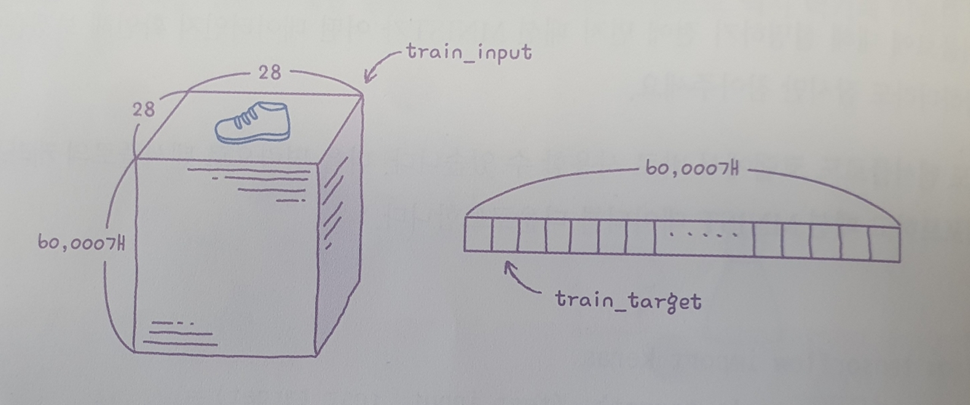  
테스트 세트의 크기도 확인해 보자.

In [3]:
print(test_input.shape, test_target.shape)

(10000, 28, 28) (10000,)


테스트 세트는 10,000개의 이미지로 이루어져 있다.  
맷플롯립 라이브러리로 과일을 출력했던 것처럼 훈련 데이터에서 몇 개의 샘플을 그림으로 출력해 보자.

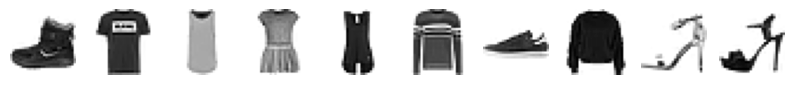

In [4]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 10, figsize=(10,10))
for i in range(10):
    axs[i].imshow(train_input[i], cmap = 'gray_r')
    axs[i].axis('off')
plt.show()

크기가 28 x 28 이기 때문에 작고 흐릿하다. 또한 반전된 흑백 이미지이다. 이 샘플들의 타깃값을 확인해 보자.  
파이썬의 리스트 내포를 사용해서 처음 10개 샘플의 타깃값을 리스트로 만든 후 출력해 보자.

In [5]:
print([train_target[i] for i in range(10)])

[9, 0, 0, 3, 0, 2, 7, 2, 5, 5]


패션 MNIST의 타깃은 0~9까지의 숫자 레이블로 구성된다. 각 숫자의 의미는 아직 모르지만 마지막 2개 샘플이같은 레이블(숫자5)를 가지고 있다. 앞서 출력한 이미지를 보더라도 이 2개의 샘플은 같은 종류의 신발로 보인다. 패션 MNIST에 포함된 10개 레이블의 의미는 다음과 같다.  
  
|<center>레이블</center>|<center>0</center>|<center>1</center>|<center>2</center>|<center>3</center>    |<center>4</center>|<center>5</center>|<center>6</center>|<center>7</center>|<center>8</center>|<center>9</center>|
|------------|--------|------|--------|--------|------|------|------|----------|------|----------|
| 패션아이템 | 티셔츠 | 바지 | 스웨터 | 드레스 | 코트 | 샌달 | 셔츠 | 스니커즈 | 가방 | 앵클부츠 |

이 값을 앞에서 출력한 결과와 비교해 보자. 마지막으로 넘파이 unique() 함수로 레이블 당 샘플 개수를 확인해 보자.

In [6]:
import numpy as np
print(np.unique(train_target, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000],
      dtype=int64))


0~9까지 레이블마다 정확히 6,000개의 샘플이 들어 있다.  
위의 과정을 통해서 패션 MNIST 데이터셋을 저장했고, 어떤 종류의 이미지로 이루어져 있는지 알 수 있다.

### 로지스틱 회귀로 패션 아이템 분류하기  
이 훈련 샘플은 60,000개나 되기 때문에 전체 데이터를 한꺼번에 사용하여 모델을 훈련하는 것 보다 샘플을 하나씩 꺼내서 모델을 훈련하는 방법이 더 효율적으로 보인다.  
이런 상황에 잘 맞는 방법이 확률적 경사 하강법이다.(SGDClassifier)

4장에서 SGDClassifier 클래스의 loss 매개변수를 'log'로 지정하여 로지스틱 손실 함수를 최소화하는 확률적 경사 하강법 모델을 만들었다.  
  
4장에서 SGDClassifier를 사용할 때 표준화 전처리된 데이터를 사용했다.  
그 이유는 확률적 경사 하강법은 여러 특성 중 기울기가 가장 가파른 방향을 따라 이동하는데 만약 특성마다 값의 범위가 많이 다르면 올바르게 손실 함수의 경사를 내려올 수 없다.  
패션 MNIST의 경우 각 픽셀은 0 ~ 255 사이의 정숫값을 가진다.  
이런 이미지의 경우 보통 255로 나누어 0 ~ 1 사이의 값으로 정규화한다. 이는 표준화는 아니지만 양수 값으로 이루어진 이미지를 전처리할 때 널리 사용하는 방법이다.

6장에서 했듯이 reshape() 메서드를 사용해 2차원 배열인 각 샘플을 1차원 배열로 펼쳐 보자.  
4장에서 보았듯이 SGDClassifier는 2차원 입력을 다루지 못하기 때문에 각 샘플을 1차원 배열로 만들어야 한다.

In [7]:
train_scaled = train_input / 255.0
train_scaled = train_scaled.reshape(-1, 28*28)

reshape() 메서드의 두 번째 매개변수를 28 x 28 이미지 크기에 맞게 지정하면 첫 번째 차원(샘플 개수)은 변하지 않고 원본 데이터의 두 번째, 세 번째 차원이 1차원으로 합쳐진다. 변환된 train_scaled의 크기를 확인해 보자.

In [8]:
print(train_scaled.shape)

(60000, 784)


784개의 픽셀로 이루어진 60,000개의 샘플이 준비되었다. 4장에서처럼 SGDClassifier 클래스와 cross_validate 함수를 사용해 이 데이터에서 교차 검증으로 성능을 확인해 보자.

In [9]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import SGDClassifier
sc = SGDClassifier(loss = 'log', max_iter = 5, random_state = 42)
scores = cross_validate(sc, train_scaled, train_target, n_jobs = -1)
print(np.mean(scores['test_score']))

i = [9, 15, 20] # max iter를 9, 15, 20으로도 입력하여 테스트
for x in i:
    sc = SGDClassifier(loss = 'log', max_iter = x, random_state = 42)
    scores = cross_validate(sc, train_scaled, train_target, n_jobs = -1)
    print(np.mean(scores['test_score']))

0.8192833333333333
0.8305833333333335
0.8367166666666666
0.84365


max_iter를 바꾸어가며 실행해도 성능이 좋지 않다.  
로지스틱 회귀 공식을 보면
$$ z = a * (Weight) + b * (Length) + c * (Diagonal) + d * (Height) + e * (Width) + f $$  
이 식을 패션 MNIST 데이터에 맞게 변형하면 다음과 같다.  
$$ z티셔츠 = w1 * (픽셀1) + w2 * (픽셀2) + ...... + w784 * (픽셀784) + b $$  
총 784개의 픽셀, 즉 특성이 있으므로 아주 긴 식이 만들어진다. 가중치 개수도 많아지기 때문에 a, b, c 대신에 w1, w2, w3과 같은 식으로 변형했다. 마지막에는 절편 b를 더한 것이다.  
생선에 대한 특성을 픽셀 특성으로 바꾼 것 뿐이다. 대신 개수가 아주 많아졌다.  
  
이번에는 두 번째 레이블인 바지에 대한 방정식을 써 보자.  
$$ z바지 = w1' * (픽셀1) + w2' * (픽셀2) + ...... + w784' * (픽셀784) + b' $$  
티셔츠에 대한 선형 방정식과 매우 비슷하다. 동일하게 784개의 픽셀값을 그대로 사용했다. 다만 바지에 대한 출력을 계산하기 위해 가중치와 절편은 다른 값을 사용해야 한다. 티셔츠와 같은 가중치를 사용한다면 바지와 티셔츠를 구분할 수가 없다.

이런 식으로 나머지 클래스에 대한 선형 방정식을 모두 생각해 볼 수 있다. SGDClassifier 모델은 패션 MNIST 데이터의 클래스를 가능한 잘 구분할 수 있도록 이 10개의 방정식에 대한 모델 파라미터(가중치와 절편)를 찾는다. 이 방정식의 계산을 그림으로 나타내면 다음과 같다.  
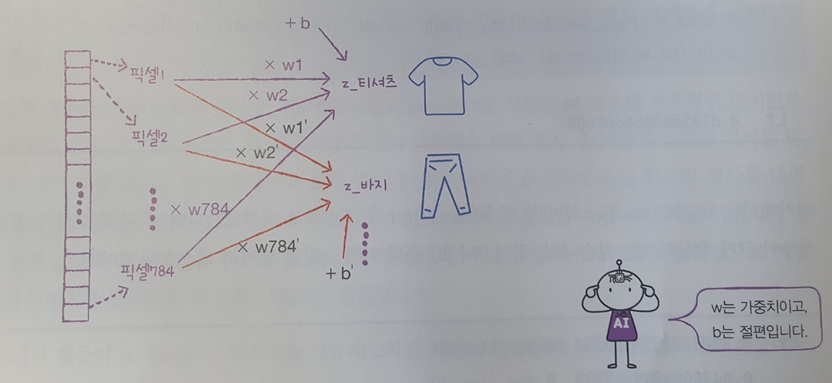  
  
첫 번째 픽셀1이 w1과 곱해져서 z_티셔츠에 더해진다. 두 번째 픽셀2도 w2와 곱해져서 z_티셔츠에 더해진다. 마지막 픽셀784도 w784와 곱해져 z_티셔츠에 더하고 절편 b를 더한다. z_바지에 대해서도 동일한 계산 과정이 수행된다.  
  
여기에서 중요한 점은 앞에서도 서술하였듯이 티셔츠를 계산하기 위해 픽셀 784개와 곱하는 가중치 784개(w1 ~ w784)와 절편(b)이 바지를 계산하기 위해 픽셀 784개와 곱하는 가중치 784개(w1' ~ w784'), 절편(b')과 다르다는 점이다.  
  
이렇게 로지스틱 회귀에 대해 짚어 보았다. 이제 인공 신경망을 만들어 패션 아이템 분류 문제의 성능을 높일 수 있는지 알아 보자.

### 인공 신경망  
가장 기본적인 인공 신경망은 확률적 경사 하강법을 사용하는 로지스틱 회귀와 같다. 패션 아이템 분류 문제를 인공 신경망으로 표현해 보자.  
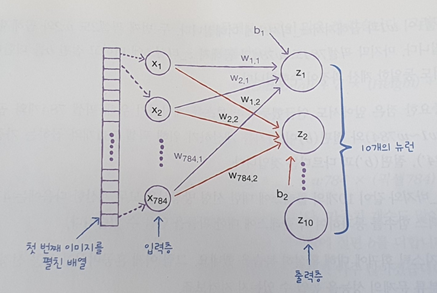  
앞서 로지스틱 회귀를 표현한 그림과 비슷하다.  여기에서는 z_티셔츠, z_바지를 z<sub>1</sub>, z<sub>2</sub>와 같이 아래첨자를 사용하도록 바꾸었다. 클래스가 총 10개이므로 z<sub>10</sub>까지 계산한다.  
z<sub>1</sub> ~ z<sub>10</sub>을 계산하고 이를 바탕으로 클래스를 예측하기 때문에 신경망의 최종 값을 만든다는 의미에서 **출력층**(output layer)이라고 부른다.  
  
인공 신경망에서는 z값을 계산하는 단위를 **뉴런**(neuron)이라고 부른다. 하지만 뉴런에서 일어나는 일은 선형 계산이 전부이다. 이제는 뉴런이라는 표현 대신에 **유닛**(unit)이라고 부르는 사람이 더 많아지고 있다.  
  
그다음 픽셀1, 픽셀2를 x<sub>1</sub>, x<sub>2</sub>와 같이 바꾸었다. 역시 아래첨자를 사용해 784번째 픽셀에 해당하는 x<sub>784</sub>까지 나타냈다. 인공 신경망은 x<sub>1</sub> ~ x<sub>784</sub>까지를 **입력층**(input layer)이라고 부른다.  
즉 입력층은 픽셀값 자체이고 특별한 계산을 수행하지 않는다. 하지만 많은 사람들이 입력층이라 부른다.  
  
z<sub>1</sub>을 만들기 위해 픽셀1인 x<sub>1</sub>에 곱해지는 가중치는 w<sub>1,1</sub>이라고 쓰고 z<sub>2</sub>를 만들기 위해 픽셀1인 x<sub>1</sub>에 곱해지는 가중치는 w<sub>1,2</sub>이라고 쓴다. 절편은 뉴런마다 하나씩이므로 순서대로 b<sub>1</sub>, b<sub>2</sub>와 같이 나타낸다.  
  
1장에서 소개했듯이 인공 신경망은 1943년 ~~~ 가 제안한 뉴런 모델로 거슬러 올라간다. 이를 **매컬러-피츠 뉴런**이라고 부른다. 이런 인공 뉴런은 생물학적 뉴런에서 영감을 얻어 만들어졌다.  
생물학적 뉴런은 수상 돌기로부터 신호를 받아 세포체에 모은다. 신호가 어떤 임계값에 도달하면 축삭 돌기를 통하여 다른 세포에 신호를 전달한다. 앞서 그렸던 인공 신경망의 출력층에 있는 인공 뉴런 하나와 비교하면 비슷하다.  
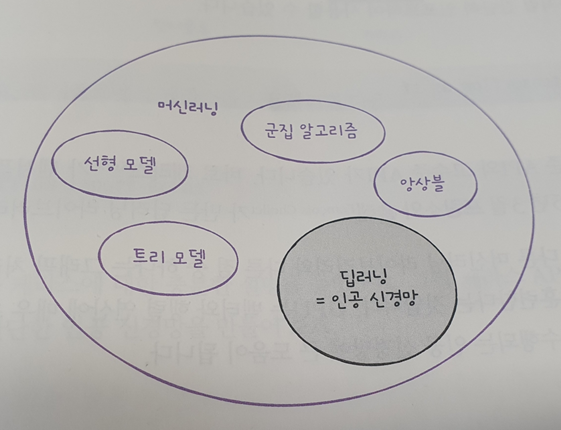

그렇다면 확률적 경사 하강법을 사용한 로지스틱 회귀 모델이 가장 간단한 인공 신경망이라면 인공 신경망을 만들어도 성능이 좋아지지 않을 것 같다. 하지만 인공 신경망 모델을 만드는 최신 라이브러리들은 SGDClassifier에 없는 몇 가지 기능을 제공한다. 이런 기능 덕분에 더 좋은 성능을 얻을 수 있다.  
  
가장 많이 쓰이는 딥러닝 라이브러리인 텐서플로를 사용해 인공 신경망 모델을 만들어 보자.

#### 텐서플로와 케라스  
텐서플로는 구글이 2015년 11월 오픈소스로 공개한 딥러닝 라이브러리이다. 다음처럼 간단히 임포트 하여 사용할 수 있다.

In [10]:
import tensorflow as tf

텐서플로에는 저수준 API와 고수준 API가 있다. 바로 **케라스**(Keras)가 텐서플로의 고수준 API이다. 케라스는 2015년 3월 프랑소와 숄레가 만든 딥러닝 라이브러리이다.  
딥러닝 라이브러리가 다른 머신러닝 라이브러리와 다른 점 하나는 그래픽 처리 장치인 GPU를 사용하여 인공 신경망을 훈련한다는 것이다. GPU는 벡터와 행렬 연산에 매우 최적화되어 있기 때문에 곱셈과 덧셈이 많이 수행되는 인공 신경망에 큰 도움이 된다.

케라스 라이브러리는 직접 GPU 연산을 수행하지 않는다. 대신 GPU 연산을 수행하는 다른 라이브러리를 백엔드로 사용한다. 예를 들면 텐서플로가 케라스의 백엔드 중 하나이다. 이외에도 씨아노, CNTK와 같은 여러 딥러닝 라이브러리를 케라스 백엔드로 사용할 수 있다. 이런 케라스를 멀티-벡엔드 케라스라고 부른다. 케라스 API만 익히면 다양한 딥러닝 라이브러리를 입맛대로 골라서 쓸 수 있다. 이를 위해 케라스는 직관적이고 사용하기 편한 고수준 API를 제공한다.  
  
텐서플로 2.0부터는 케라스 API를 남기고 나머지 고수준 API를 모두 정리했다. 케라스는 텐서플로의 핵심 API가 되었다.

In [11]:
from tensorflow import keras

케라스 API를 사용해 패션 아이템을 분류하는 가장 간단한 인공 신경망을 만들어 보자.

### 인공 신경망으로 모델 만들기  
앞서 로지스틱 회귀에서 만든 훈련 데이터 train_scaled와 train_target을 사용한다. 로지스틱 회귀에서는 교차 검증을 사용해 모델을 평가했지만, 인공 신경망에서는 교차 검증을 잘 사용하지 않고 검증 세트를 별도로 덜어내어 사용한다.  
  
이렇게 하는 이유는 ① 딥러닝 분야의 데이터셋은 충분히 크기 때문에 검증 점수가 안정적이고, ② 교차 검증을 수행하기에는 훈련 시간이 너무 오래 걸리기 때문이다.  
패션 MNIST 데이터셋이 그만큼 크지는 않지만, 관례에 따라 검증 세트를 나누어 보자. 사이킷런의 train_test_split() 함수를 사용한다.

In [12]:
from sklearn.model_selection import train_test_split
train_scaled, val_scaled, train_target, val_target = train_test_split(
train_scaled, train_target, test_size = 0.2, random_state = 42)

##### 사실 패션 MNIST 데이터는 이미 잘 섞여있는 데이터라서 앞이나 뒤에서 10,000개 정도의 샘플을 덜어서 검증 세트로 만들어도 되지만, 일반적인 상황을 가정하여 섞어서 나누었다.

훈련 세트에서 20%를 검증 세트로 덜어 내었다. 훈련 세트와 검증 세트의 크기를 알아보자.

In [13]:
print(train_scaled.shape, train_target.shape)

(48000, 784) (48000,)


In [14]:
print(val_scaled.shape, val_target.shape)

(12000, 784) (12000,)


60,000개 중에 12,000개가 검증 세트로 분리되었다. 먼저 훈련 세트(train_scaled, train_target)로 모델은 만든다. 그다음 검증 세트(val_scaled, val_target)로 훈련한 모델을 평가해 보자.  
  
먼저 인공 신경망 그림의 오른쪽에 놓인 층을 만들어 보자. 이 층은 다음 그림처럼 10개의 패션 아이템을 분류하기 위해 10개의 뉴런으로 구성된다.  
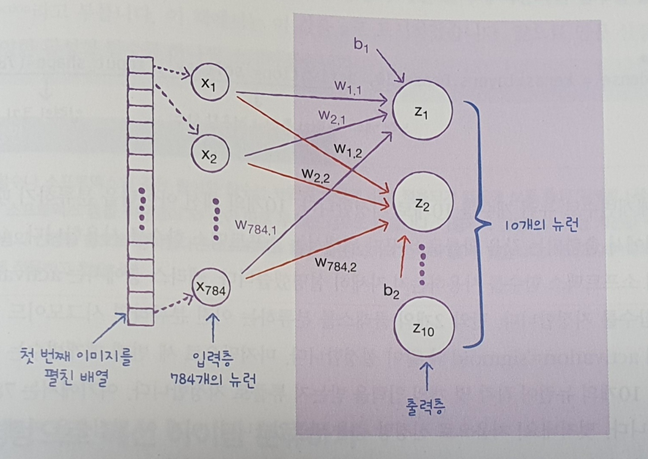  
케라스의 레이어(keras.layer) 패키지 안에는 다양한 층이 준비되어 있다. 가장 기본이 되는 층은 **밀집층**(dense layer)이다.  
왜 밀집일까? 다음 그림에서 왼쪽에 있는 784개의 픽셀과 오른쪽에 있는 10개의 뉴런이 모두 연결된 선을 생각해 보자. 784 x 10 = 7,840개의 연결된 선이 있다. 빽빽하기 때문에 밀집층이다.  
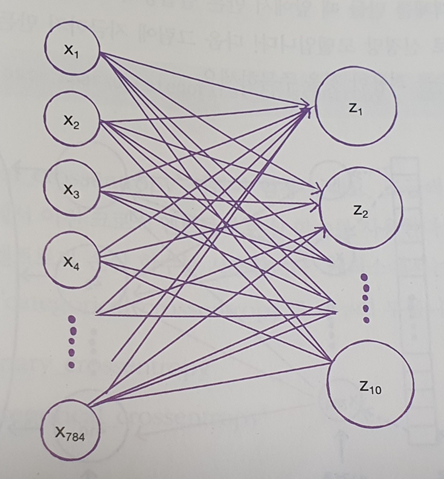  
이런 층을 양쪽의 뉴런이 모두 연결하고 있기 때문에 **완전 연결층**(fully connected layer)이라고 부른다. 그럼 케라스의 Dense 클래스를 사용해 밀집층을 만들어 보자. 필요한 매개변수는 뉴런 개수, 뉴런의 출력에 적용할 함수, 입력의 크기이다.

In [15]:
#                       뉴런개수     뉴런의 출력에 적용할 함수    입력의 크기
dense = keras.layers.Dense(10, activation = 'softmax', input_shape = (784,))

첫 번째 매개변수로 뉴런 개수를 10개로 지정한다. 10개의 패션 아이템을 분류하기 때문이다.  
10개의 뉴런에서 출력되는 값을 확률로 바꾸기 위해 소프트맥스 함수를 사용한다. 4장의 다중 분류 내용에서 왜 소프트맥스 함수를 사용하는지 알 수 있다.  
케라스 층에서는 activation 매개변수에 이 함수를 지정한다.  
만약 2개의 클래스를 분류하는 이진 분류라면 시그모이드 함수를 사용하기 위해 = 'sigmoid'와 같이 설정한다.  
마지막으로 세 번째 매개변수는 입력값의 크기이다. 10개의 뉴런이 각각 몇 개의 입력을 받는지 튜플로 지정한다. 여기에서는 784개의 픽셀값을 받는다.  
이 밀집층을 가진 신경망 모델을 만들어야 하기 때문에 케라스의 Sequential 클래스를 사용한다.

In [16]:
model = keras.Sequential(dense)

Sequential 클래스의 객체를 만들 때 앞에서 만든 밀집층의 객체 dense를 전달하였다. 여기서 만든 model 객체가 바로 신경망 모델이다.  
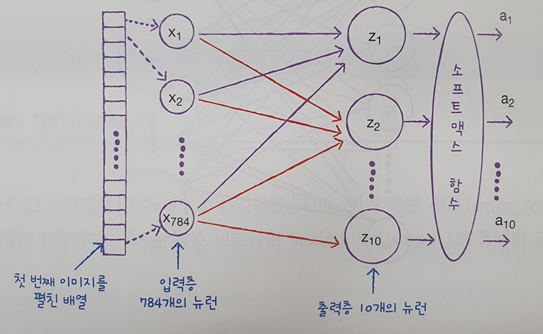  
입력층과 출력층 사이에 연결선만 나타내고 가중치는 표시하지 않았다. 절편의 경우에는 선도 그리지 않는 경우가 많다. 하지만 절편이 뉴런마다 더해진다는 것을 알고 있어야 한다.  
소프트맥스와 같이 뉴런의 선형 방정식 계산 결과에 적용되는 함수를 **활성화 함수**(activation function)라고 부른다. 이 값을 a로 표시한다.

#### 소프트맥스 함수는 별도의 층인가?  
시그모이드 함수나 소프트맥스와 같은 활성화 함수는 뉴런의 출력에 바로 적용되기 때문에 보통 층의 일부로 나타낸다. 가중치와 절편으로 선형 계산을 수행하는 층을 좁은 개념의 신경망 층으로 생각한다면 소프트맥스 층은 넓은 의미의 층이라고 볼 수 있다. 케라스 API에서도 층의 개념을 폭 넓게 적용하고 있다.

### 인공 신경망으로 패션 아이템 분류하기  
케라스 모델은 훈련하기 전에 설정 단계가 있다. 이런 설정을 model 객체의 compile() 메서드에서 수행한다. 꼭 지정해야 할 것은 손실 함수의 종류이다. 그다음 훈련 과정에서 계산하고 싶은 측정값을 지정한다.

In [17]:
model.compile(loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')

4장의 이진 분류에서 이진 크로스 엔트로피 손실 함수를 사용했었다. 다중 분류에서는 크로스 엔트로피 손실 함수를 사용한다.  
케라스에서는 이 두 손실 함수를 각각 'binary_crossentropy', 'categorical_crossentropy'로 나누어 부른다.  
- 이진 분류 : loss = 'binary_crossentropy'
- 다중 분류 : loss = 'categorical_crossentropy'  
sparse라는 단어는 왜 앞에 붙었을까?  
4장의 내용에서 이진 크로스 엔트로피 손실을 위해 -log(예측 확률)에 타깃값(정답)을 곱했다.  
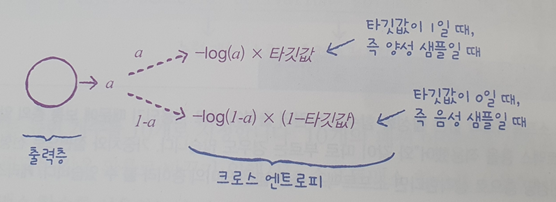  
이진 분류에서는 출력층의 뉴런이 하나이다. 이 뉴런이 출력하는 확률값 a(시그모이드 함수의 출력값)를 사용해 양성 클래스와 음성 클래스에 대한 크로스 엔트로피를 계산한다. 이 계산은 4장에서 본 로지스틱 손실 함수와 동일하다.  
  
이진 분류의 출력 뉴런은 오직 양성 클래스에 대한 확률(a)만 출력하기 때문에 음성 클래스에 대한 확률은 간단히 1-a 로 구할 수 있다.  
이진 분류의 타깃값은 양성 샘플인 경우 1, 음성 샘플인 경우 0으로 되어 있다. 0을 곱하면 어떤 계산이든지 모두 0이 되기 때문에 특별히 음성 샘플인 경우 1로 바꾸어(1-타깃값) 계산한다.  
이렇게 하면 하나의 뉴런만으로 양성과 음성 클래스에 대한 크로스 엔트로피 손실을 모두 계산할 수 있다.  
  
MNIST 데이터셋과 같이 다중 분류일 경우 어떻게 계산할 수 있을까?  
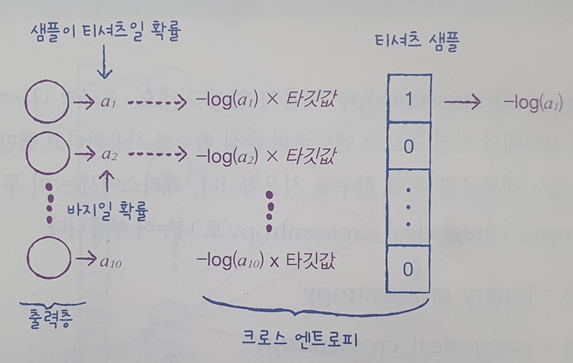  
출력층은 10개의 뉴런이 있고 10개의 클래스에 대한 확률을 출력한다. 첫 번째 뉴런은 티셔츠일 확률이고 두 번째 뉴런은 바지일 확률을 출력한다. 이진 분류와 달리 각 클래스에 대한 확률이 모두 출력되기 때문에 타깃에 해당하는 확률만 남겨 놓기 위해서 나머지 확률에는 모두 0을 곱한다.  
  
예를 들어 샘플이 티셔츠일 경우 첫 번째 뉴런의 활성화 함수 출력인 a<sub>1</sub>에 크로스 엔트로피 손실 함수를 적용하고 나머지 활성화 함수 출력 a<sub>2</sub> ~ a<sub>10</sub>까지는 모두 0으로 만든다. 이렇게 하기 위해서 티셔츠 샘플의 타깃값은 첫 번째 원소만 1이고 나머지는 모두 0인 배열로 만들 수 있다.  
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
이 배열과 출력층의 활성화 값의 배열과 곱하면 된다.  
[a<sub>1</sub>, a<sub>2</sub>, a<sub>3</sub>, a<sub>4</sub>, a<sub>5</sub>, a<sub>6</sub>, a<sub>7</sub>, a<sub>8</sub>, a<sub>9</sub>, a<sub>10</sub>] x [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
길이가 같은 넘파이 배열의 곱셈은 원소별 곱셈으로 수행된다. 즉, 배열에서 동일한 위치의 원소끼리 곱셈이 된다. 결국 다른 원소는 모두 0이 되고 a<sub>1</sub>만 남는다.  
  
결국 신경망은 티셔츠 샘플에서 손실을 낮추려면 첫 번째 뉴런의 활성화 출력 a<sub>1</sub>의 값을 가능한 1에 가깝게 만들어야 한다. 이것이 크로스 엔트로피 손실 함수가 신경망에 원하는 것이다. 만약 샘플이 바지일 경우에는 다음과 같다.  
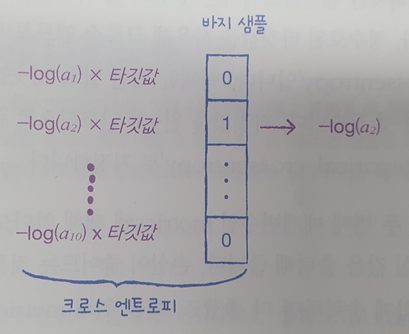  
두 번째 뉴런의 활성화 출력인 a<sub>2</sub>만 남기려면 두 번째 원소만 1이고 나머지는 모두 0으로 타깃값을 준비하면 된다. 바지 샘플을 정확하게 분류하려면 신경망이 a<sub>2</sub>의 출력을 가능한 한 높여야 한다.  
이와 같이 타깃값을 해당 클래스만 1이고 나머지는 모두 0인 배열로 만드는 것을 **원-핫 인코딩**(one-hot encoding)이라고 부른다.  
따라서 다중 분류에서 크로스 엔트로피 손실 함수를 사용하려면 0, 1, 2와 같이 정수로 된 타깃값을 원-핫 인코딩으로 변환해야 한다.  
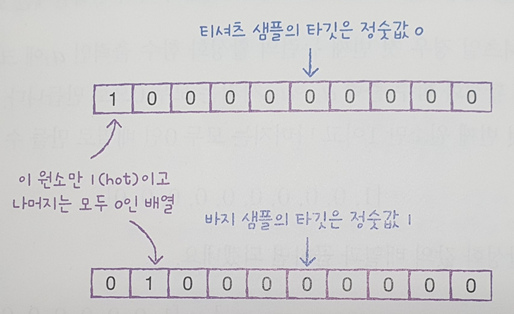

In [18]:
print(train_target[:10])

[7 3 5 8 6 9 3 3 9 9]


패션 MNIST 데이터의 타깃값은 모두 정수로 되어 있다. 하지만 텐서플로에서는 정수로 된 타깃값을 원-핫 인코딩으로 바꾸지 않고 그냥 사용이 가능하다.  
정수로 된 타깃값을 사용해 크로스 엔트로피 손실을 계산하는 것이 바로 'sparse_categorical_crossentropy'이다. 빽빽한 배열이 아닌 정수값 하나만 사용한다는 뜻으로 sparse라는 이름이 붙었다.  
타깃값을 원-핫 인코딩으로 준비했다면 compile() 메서드에 손실 함수를 loss = 'categorical_crossentropy'로 지정한다.  
  
이제 compile() 메서드의 두 번째 매개변수인 metrics에 대해 알아보자. 케라스는 모델이 훈련할때 기본으로 에포크마다 손실값을 출력해 준다. 손실이 줄어드는 것을 보고 훈련이 잘되었다는 것을 알 수 있지만 정확도를 함께 출력하면 더 좋을 것이다. 이를 위해 metrics 매개변수에 정확도 지표를 의미하는 'accuracy'를 지정했다.  
  
이제 모델을 훈련해 보자. 훈련하는 fit() 메서드는 사이킷런과 매우 비슷하다. 처음 두 매개변수에 입력(train_scaled)과 타깃(train_target)을 지정한다. 그다음 반복할 에포크 횟수를 epochs 매개변수로 지정한다.  
사이킷런의 로지스틱 모델과 동일하게 5번 반복해 보자.

In [19]:
model.fit(train_scaled, train_target, epochs = 5)

Epoch 1/5
1500/1500 [==============================] - 6s 3ms/step - loss: 0.6082 - accuracy: 0.7955
Epoch 2/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4794 - accuracy: 0.8391
Epoch 3/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4560 - accuracy: 0.8474
Epoch 4/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4443 - accuracy: 0.8529
Epoch 5/5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.4374 - accuracy: 0.8550


5번 반복에 정확도가 85%가 넘어 로지스틱 회귀보다 나은 성능을 보인다. 앞서 따로 떼어 놓은 검증 세트(val_scaled, val_target)에서 모델의 성능을 확인해 보자.  
케라스에서 모델의 성능을 평가하는 메서드는 evaluate() 메서드이다.

In [20]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 3ms/step - loss: 0.4510 - accuracy: 0.8476


[0.4509705901145935, 0.8475833535194397]

evaluate() 메서드도 fit() 메서드와 비숫한 출력을 보여준다. 검증 세트의 점수는 훈련 세트 점수보다 조금 낮은 것이 일반적이다.

### 인공 신경망 모델로 성능 향상(정리)  
이 절에서는 28 x 28 크기의 흑백 이미지로 저장된 패션 아이템 데이터셋인 패션 MNIST 데이터 셋을 사용했다. 먼저 로지스틱 손실 함수를 사용한 SGDClassifier 모델을 만들어 교차 검증 점수를 확인했다.  
그다음 딥러닝 라이브러리인 텐서플로와 케라스 API를 알아보고 케라스를 사용해 간단한 인공 신경망 모델을 만들어 패션 아이템을 분류해 보았다. 이 인공 신경망은 사실상 앞에서 만든 경사 하강법을 사용한 로지스틱 회귀 모델과 거의 비슷하다. 하지만 몇 가지 장점으로 조금 더 높은 성능을 나타낸다.  
  
인공 신경망 모델을 만들면서 이전 장에서 배웠던 로지스틱 손실 함수와 크로스 엔트로피 손실 함수를 복습하였고 신경망에서 이런 손실 함수를 어떻게 계산하는지 확인하였다.  
  
다음 그림은 사이킷런의 SGDClassifier와 케라스의 Sequential 클래스의 사용법의 차이를 나타낸다.  
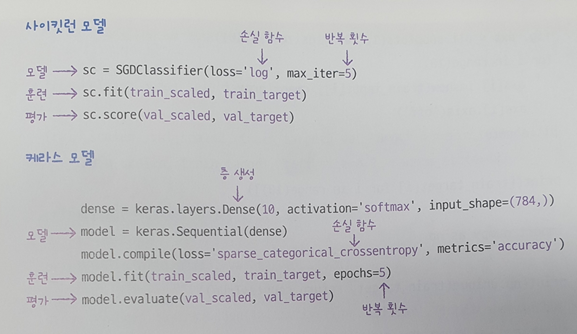

- **인공 신경망**  
뉴런에서 영감을 받아 만든 머신러닝 알고리즘.

### Tensorflow  
- **Dense**  
신경망에서 가장 기본 층인 밀집층을 만드는 클래스이다.  
이 층의 <font color=teal>첫 번째 매개변수</font>에는 뉴런의 개수를 지정한다.  
<font color=teal>activation</font> 매개변수에는 사용할 활성화 함수를 지정한다. 대표적으로 'sigmoid', 'softmax' 함수가 있다. 아무것도 지정하지 않으면 활성화 함수를 사용하지 않는다.  
케라스의 Sequential 클래스에 맨 처음 추가되는 층에는 <font color=teal>input_shape</font> 매개변수로 입력의 크기를 지정해야 한다.  
  
- **Sequential**  
케라스에서 신경망 모델을 만드는 클래스이다.  
이 클래스의 객체를 생성할 때 신경망 모델에 추가할 층을 지정할 수 있다. 추가할 층이 1개 이상일 경우 파이썬 리스트로 전달한다.  
  
- **compile()**  
모델 객체를 만든 후 훈련하기 전에 사용할 손실 함수와 측정 지표 등을 지정하는 메서드이다.  
<font color=teal>loss</font> 매개변수에 손실 함수를 지정한다. 이진 분류일 경우 'binary_crossentropy', 다중 분류일 경우 'categorical_crossentropy'를 지정한다. 클래스 레이블이 정수일 경우 'sparse_categorical_crossentropy'로 지정한다. 회귀 모델일 경우 'mean_square_error'등으로 지정한다.  
<font color=teal>metrics</font> 매개변수에 훈련 과정에서 측정하고 싶은 지표를 지정할 수 있다. 측정 지표가 1개 이상일 경우 리스트로 전달한다.  
  
- **fit()**  
모델을 훈련하는 메서드이다.  
첫 번째와 두 번째 매개변수에 입력과 타겟 데이터를 전달한다.  
<font color=teal>epochs</font> 매개변수에 전체 데이터에 대해 반복할 에포크 횟수를 지정한다.  
  
- **evaluate()**  
첫 번째와 두 번째 매개변수에 입력과 타깃 데이터를 전달한다.  
compile() 메서드에서 loss 매개변수에 지정한 손실 함수의 값과 metrics 매개변수에서 지정한 측정 지표를 출력한다.